In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import HDF5Matrix
from PIL import Image

import tensorflow as tf
import keras
from keras import backend as K
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

from keras import Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.metrics import categorical_crossentropy

from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input

import os
import time
from IPython import display

#print(os.listdir("../input"))

In [2]:
# Import dataset
x_train = HDF5Matrix('../input/camelyonpatch_level_2_split_train_x.h5-002/camelyonpatch_level_2_split_train_x.h5-002', 'x')
mask_train = HDF5Matrix('../input/camelyonpatch_level_2_split_train_mask.h5/camelyonpatch_level_2_split_train_mask.h5', 'mask')
y_train = HDF5Matrix('../input/camelyonpatch_level_2_split_train_y.h5/camelyonpatch_level_2_split_train_y.h5', 'y')               
x_val = HDF5Matrix('../input/camelyonpatch_level_2_split_valid_x.h5/camelyonpatch_level_2_split_valid_x.h5', 'x')
y_val = HDF5Matrix('../input/camelyonpatch_level_2_split_valid_y.h5/camelyonpatch_level_2_split_valid_y.h5', 'y')
x_test = HDF5Matrix('../input/camelyonpatch_level_2_split_test_x.h5/camelyonpatch_level_2_split_test_x.h5', 'x')


In [3]:
# Check dimensions
print("Training set")
print("img:",x_train.shape)
print("labels:",y_train.shape)
print('-'*40)
print("Validation set")
print("img:",x_val.shape)
print("labels:",y_val.shape)
print('-'*40)
print("Test set")
print("img:",x_test.shape)

Training set
img: (262144, 96, 96, 3)
labels: (262144, 1, 1, 1)
----------------------------------------
Validation set
img: (32768, 96, 96, 3)
labels: (32768, 1, 1, 1)
----------------------------------------
Test set
img: (32768, 96, 96, 3)


In [10]:
# indexes
train_id = np.arange(262144)
val_id = np.arange(32768)

# creat a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id


train_labels = {}
val_labels = {}

for i in range(len(train_id)):
    
    train_labels[str(i)] = y_train[i].flatten()[0] 
    
for i in range(len(val_id)):
    
    val_labels[str(i)] = y_val[i].flatten()[0]

In [36]:
#Data Generator to efficiently load and preprocess data for training the classifier

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, data, labels, batch_size=32, dim=(224, 224), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.data = data
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # preprocessing
            img_arr = self.data[ID]
            img = array_to_img(img_arr)
            img = img.resize((224,224), Image.ANTIALIAS)
            img.load()
            
            X[i] = preprocess_input(np.asarray(img, dtype=np.uint8))
            
            
            

            # Store target label(one-hot-encoding)
            y[i] = to_categorical(self.labels[str(ID)], num_classes=self.n_classes)

        return X, y

In [14]:
# create a copy of a mobilenet model

mobile = keras.applications.mobilenet.MobileNet()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
17227776/17225924 [==============================] - 1s 0us/step


In [15]:
mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [18]:
# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(2, activation='softmax')(x)


model = Model(inputs=mobile.input, outputs=predictions)

In [19]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [20]:
model.compile(Adam(lr=0.01, beta_1=0.9, beta_2=0.999,), loss='categorical_crossentropy', 
              metrics=['acc'])

In [21]:
def train_network(network, training_generator, validation_generator, n_epoch, network_filepath):


    
    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy

    for epoch in range(n_epoch):
        st = time.time()

        # Train your network
        results = network.fit_generator(training_generator)

        # Get training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['acc']

        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate_generator(validation_generator)     
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'g')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt], 
                  ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

In [34]:
# Define batch size.
batch_size = 32
n_epoch = 20


# Parameters for generators
params = {'dim': (224, 224),
          'batch_size': batch_size,
          'n_classes': 2,
          'shuffle': True}

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **params)
validation_generator = DataGenerator(partition['validation'], x_val, val_labels, **params)

In [23]:
# directory to save the best model

file_dir = '../working//Model'
network_filepath = os.path.join(file_dir, 'best_model.h5')
os.mkdir(file_dir)

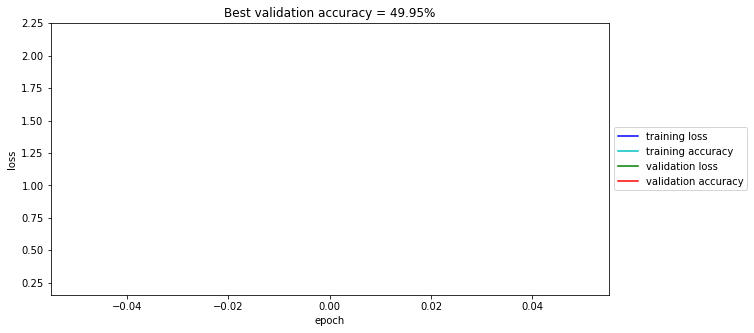

Epoch 1/1
1040/8192 [==>...........................] - ETA: 14:49 - loss: 0.2042 - acc: 0.9229

KeyboardInterrupt: 

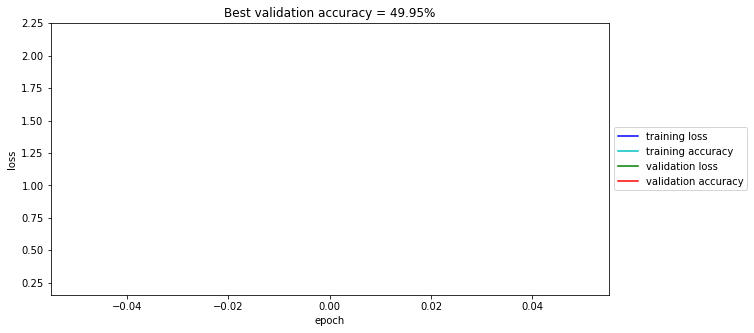

In [35]:
# Train the model 

train_network(model, training_generator, validation_generator, n_epoch, network_filepath)